In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
from spectral_clustering import *
from stability_analysis import *
from parameter_fitting import *
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings(
    "ignore", message="KMeans is known to have a memory leak on Windows with MKL"
)

In [4]:
data = pd.read_csv(project_root + "/Data/glass.csv")

Motivation for the scaler?

In [5]:
scaler = StandardScaler()
X = scaler.fit_transform(data.drop(columns=["Type"]).to_numpy())
y_true = data["Type"].to_numpy()

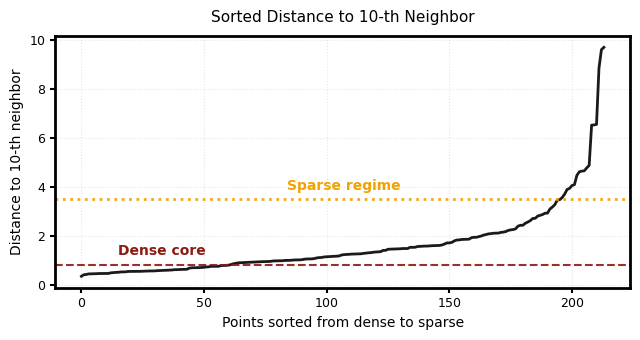

In [6]:
k = 10
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, _ = nbrs.kneighbors(X)
dist_to_kth_neighbor = distances[:, k - 1]
sorted_distances = np.sort(dist_to_kth_neighbor)

# --- Plotting ---
fig, ax1 = plt.subplots(1, 1, figsize=(6.5, 3.5))

dense_color = PRESENTATION_COLORS[0]  # Burgundy
sparse_color = PRESENTATION_COLORS[4]  # Amber Accent

# Main line
ax1.plot(sorted_distances, color="#1a1a1a", linewidth=2)

# --- Styling to match the screenshot ---

# 1. Thick Black Frame (Spines) to match stability plots
for spine in ax1.spines.values():
    spine.set_linewidth(2)
    spine.set_color("black")

# 2. Subtle Dotted Grid
ax1.grid(True, linestyle=":", color="gray", alpha=0.2)

# 3. Horizontal Guide Lines
ax1.axhline(0.8, color=dense_color, linestyle="--", linewidth=1.5, alpha=0.9)
ax1.axhline(3.5, color=sparse_color, linestyle=":", linewidth=2.0, alpha=0.9)

# 4. Text Annotations
ax1.text(
    15,
    1.1,
    "Dense core",
    fontsize=10,
    fontweight="bold",
    color=dense_color,
    ha="left",
    va="bottom",
)
ax1.text(
    len(sorted_distances) // 2,
    3.75,
    "Sparse regime",
    fontsize=10,
    fontweight="bold",
    color=sparse_color,
    ha="center",
    va="bottom",
)

# 5. Label and Title Formatting
ax1.set_title(f"Sorted Distance to {k}-th Neighbor", fontsize=11, pad=10)
ax1.set_xlabel("Points sorted from dense to sparse", fontsize=10)
ax1.set_ylabel(f"Distance to {k}-th neighbor", fontsize=10)

# 6. Adjust Ticks
ax1.tick_params(axis="both", labelsize=9, width=1.5)

plt.tight_layout()
plt.show()

We observe that the data has varying density, which means that knn or mutual knn might be the best graph type

In [7]:
distance_matrix = get_distance_matrix_from_data(X)

In [8]:
parameter_grid_fully_connected = {
    "sim_graph_type": ["fully_connect"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [
        # 0.01, # Too small. Produce isolated clusters
        # 0.02,
        # 0.03,
        # 0.04,
        # 0.05,
        0.1,
        0.15,
        0.2,
        0.25,
        0.3,
        0.4,
        0.5,
        0.6,
        0.75,
        1.0,
        1.5,
        2.0,
    ],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_knn = {
    "sim_graph_type": ["knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [3, 5, 6, 7, 8, 10, 12, 15, 17, 20, 23, 27, 30, 35, 40],
    "mutual_knn": [0],
    "epsilon": [0],
}

parameter_grid_mutual_knn = {
    "sim_graph_type": ["mutual_knn"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [5, 6, 7, 8, 10, 12, 15, 17, 20, 23, 27, 30, 35, 40],
    "epsilon": [0],
}

parameter_grid_eps_neighborhood = {
    "sim_graph_type": ["eps_neighbor"],
    "K": [50],  # Just a place holder, doesn't affect anything
    "sigma": [0],
    "knn": [0],
    "mutual_knn": [0],
    "epsilon": [
        # 0.05, Too small, produce lots of singleton clusters
        # 0.1,
        # 0.15,
        0.2,
        0.25,
        0.3,
        0.5,
        0.75,
        1.0,
        1.25,
        1.5,
        2.0,
        4.0,
        8.0,
    ],
}

In [9]:
best_params_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix, param_grid=parameter_grid_knn, random_state=1
)
print(best_params_knn)

best_params_mutual_knn = find_best_params_with_eigengap_grid_search(
    distance_matrix,
    param_grid=parameter_grid_mutual_knn,
    random_state=1,
)
print(best_params_mutual_knn)

{'K': 2, 'epsilon': 0, 'knn': 10, 'mutual_knn': 0, 'sigma': 0, 'sim_graph_type': 'knn'}
{'K': 4, 'epsilon': 0, 'knn': 0, 'mutual_knn': 40, 'sigma': 0, 'sim_graph_type': 'mutual_knn'}


In [10]:
params_knn = {
    "K": 3,
    "epsilon": 0,
    "knn": 5,
    "mutual_knn": 0,
    "sigma": 0,
    "sim_graph_type": "knn",
}

In [11]:
similarity_matrix_knn_best = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=best_params_knn["sim_graph_type"],
    knn=best_params_knn["knn"],
)

res_knn_best = Spectral_Clustering(
    similarity_matrix_knn_best,
    K=best_params_knn["K"],
    random_state=1,
)

similarity_matrix_knn_5 = get_similarity_matrix_from_distance_matrix(
    distance_matrix,
    sim_graph_type=params_knn["sim_graph_type"],
    knn=params_knn["knn"],
)

res_knn_5 = Spectral_Clustering(
    similarity_matrix_knn_5,
    K=params_knn["K"],
    random_state=1,
)

In [12]:
K_folds = 10

stability_res_knn_ami = cross_validation_stability_test(
    distance_matrix,
    params=best_params_knn,
    K_folds=K_folds,
    info_score=adjusted_mutual_info_score,
)

stability_res_knn_ars = cross_validation_stability_test(
    distance_matrix,
    params=best_params_knn,
    K_folds=K_folds,
    info_score=adjusted_rand_score,
)

Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.9255
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.9256
Mean info_score: 0.9851
Std  info_score: 0.0298
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 0.9684
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 5: info_score(

<Axes: title={'center': 'Stability Across Folds'}, xlabel='Fold', ylabel='Stability Score'>

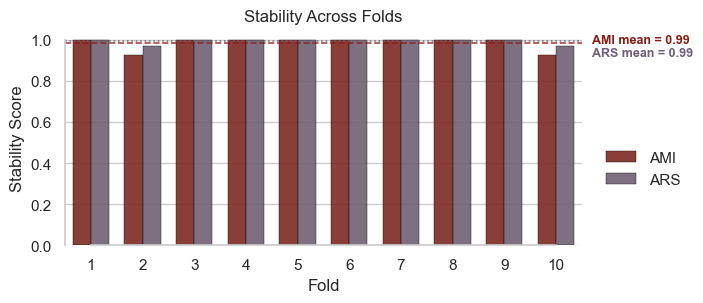

In [13]:
plot_cross_validation_stability_test_result(
    stability_res_knn_ami, stability_res_knn_ars
)

In [14]:
K_folds = 10

stability_res_knn_ami = cross_validation_stability_test(
    distance_matrix,
    params=params_knn,
    K_folds=K_folds,
    info_score=adjusted_mutual_info_score,
)

stability_res_knn_ars = cross_validation_stability_test(
    distance_matrix,
    params=params_knn,
    K_folds=K_folds,
    info_score=adjusted_rand_score,
)

Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.9378
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8055
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.9378
Labels shape:  (193,)
Fold 5: info_score(train vs full) = 0.9431
Labels shape:  (193,)
Fold 6: info_score(train vs full) = 0.9395
Labels shape:  (193,)
Fold 7: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 8: info_score(train vs full) = 0.8950
Labels shape:  (193,)
Fold 9: info_score(train vs full) = 1.0000
Labels shape:  (193,)
Fold 10: info_score(train vs full) = 0.9395
Mean info_score: 0.9398
Std  info_score: 0.0556
Labels shape:  (192,)
Fold 1: info_score(train vs full) = 0.9687
Labels shape:  (192,)
Fold 2: info_score(train vs full) = 1.0000
Labels shape:  (192,)
Fold 3: info_score(train vs full) = 0.8602
Labels shape:  (192,)
Fold 4: info_score(train vs full) = 0.9687
Labels shape:  (193,)
Fold 5: info_score(

<Axes: title={'center': 'Stability Across Folds'}, xlabel='Fold', ylabel='Stability Score'>

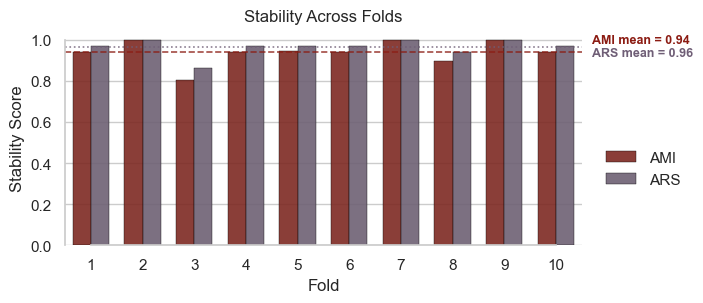

In [15]:
plot_cross_validation_stability_test_result(
    stability_res_knn_ami, stability_res_knn_ars
)

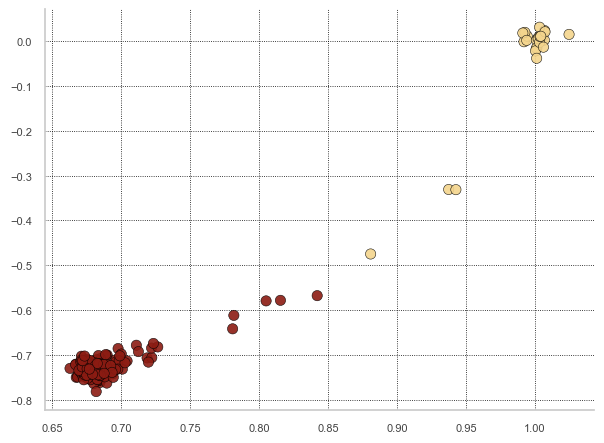

In [16]:
row_norms = np.linalg.norm(res_knn_best.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-25
normalized_embedding = res_knn_best.eigenvectors / row_norms

plot_2d_spectral_embedding(
    normalized_embedding,
    cluster_labels=res_knn_best.labels,
    # true_labels=y_true,
)

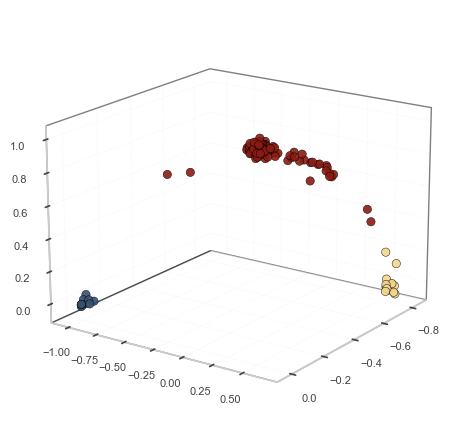

(<Figure size 620x460 with 1 Axes>, <Axes3D: >)

In [17]:
row_norms = np.linalg.norm(res_knn_5.eigenvectors, axis=1, keepdims=True)
row_norms[row_norms == 0] = 1e-25
normalized_embedding = res_knn_5.eigenvectors / row_norms

plot_3d_spectral_embedding(
    normalized_embedding,
    cluster_labels=res_knn_5.labels,
    # true_labels=y_true,
)

We have established that only kNN produces clusters that are not too small. Let us now try to find stable parameters for kNN, such that we get at least 3 large clusters

In [18]:
K_values = [2, 3, 4, 5, 6, 7, 8]
knn_values = [5, 10, 20, 30, 40]

knn_param_grid = {
    K: {
        knn_value: {
            "sim_graph_type": "knn",
            "K": K,
            "sigma": [0],
            "knn": knn_value,
            "mutual_knn": [0],
            "epsilon": [0],
        }
        for knn_value in knn_values
    }
    for K in K_values
}


def iter_knn_param_grid():
    for K in K_values:
        for knn_value, params in knn_param_grid[K].items():
            yield K, knn_value, params

In [19]:
knn_results = {K: {} for K in K_values}

for K, knn_value, params in iter_knn_param_grid():
    similarity_matrix = get_similarity_matrix_from_distance_matrix(
        distance_matrix,
        sim_graph_type=params["sim_graph_type"],
        knn=params["knn"],
    )
    knn_results[K][knn_value] = Spectral_Clustering(
        similarity_matrix,
        K=params["K"],
        random_state=1,
    )

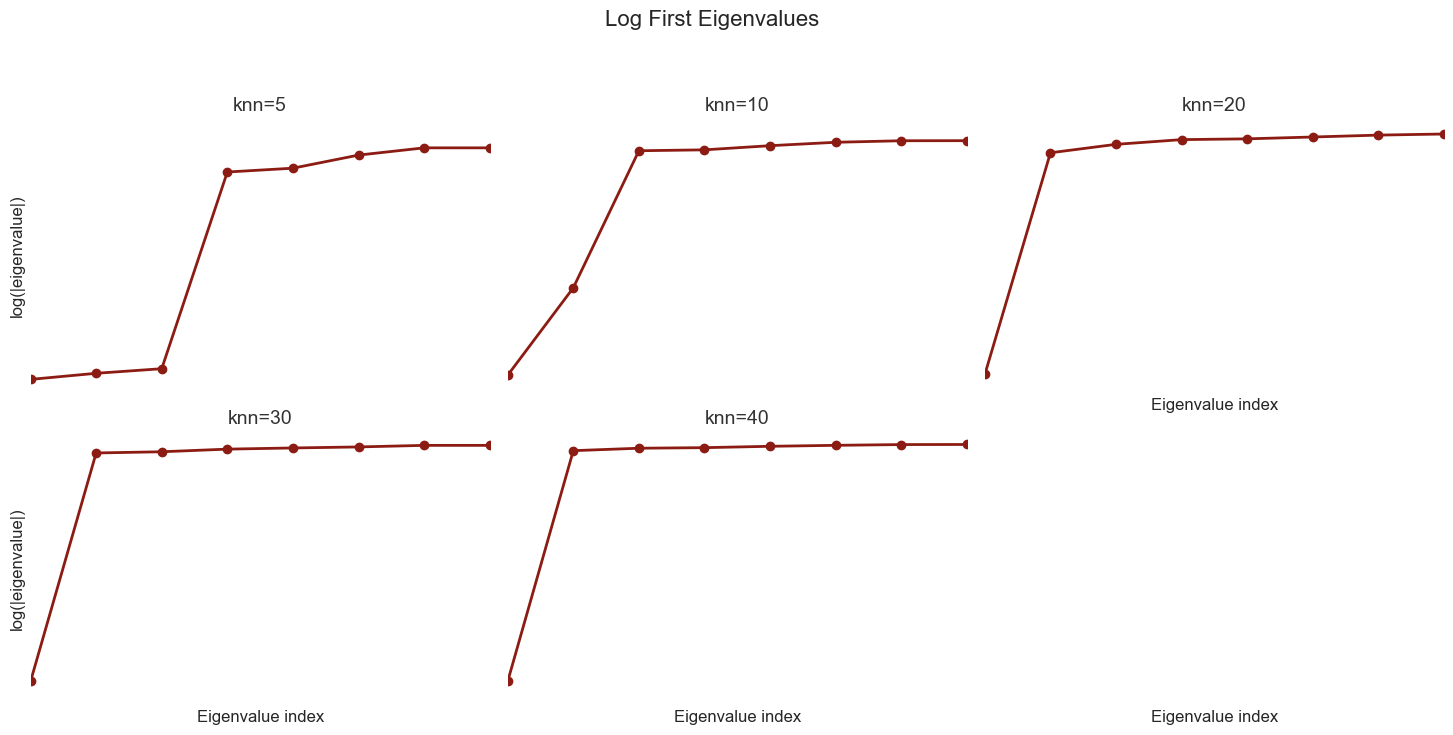

In [20]:
selected_K = 4
eigenvalue_sets = [
    knn_results[selected_K][knn_value].eigenvalues for knn_value in knn_values
]
labels = [f"knn={knn_value}" for knn_value in knn_values]
plot_eigenvalues(eigenvalue_sets, labels=labels, n_first=8)

In [21]:
# cluster_size_records = []

# for K in K_values:
#     for knn_value in knn_values:
#         labels = knn_results[K][knn_value].labels
#         counts = np.bincount(labels, minlength=K)
#         for cluster_idx, count in enumerate(counts, start=1):
#             cluster_size_records.append(
#                 {
#                     "K": K,
#                     "knn": knn_value,
#                     "cluster": cluster_idx,
#                     "count": int(count),
#                 }
#             )

# cluster_size_df = pd.DataFrame(cluster_size_records)


# def plot_cluster_size_overview(cluster_size_df, K_values, knn_values):
#     spacing_factor = 0.78
#     x_positions = np.arange(len(knn_values)) * spacing_factor
#     fig, axes = plt.subplots(
#         len(K_values),
#         1,
#         figsize=(6.4, 1.35 * len(K_values)),
#         sharex=True,
#     )
#     if not isinstance(axes, np.ndarray):
#         axes = np.array([axes])
#     palette = PRESENTATION_COLORS
#     palette_len = len(palette)

#     for ax, K in zip(axes, K_values):
#         subset = cluster_size_df[cluster_size_df["K"] == K]
#         knn_totals = (
#             subset.groupby("knn")["count"]
#             .sum()
#             .reindex(knn_values, fill_value=0)
#             .to_numpy()
#         )
#         knn_totals[knn_totals == 0] = 1
#         bottom = np.zeros(len(knn_values))
#         min_percentages = np.full(len(knn_values), 100.0)
#         min_centers = np.zeros(len(knn_values))
#         for cluster_idx in range(1, K + 1):
#             counts = (
#                 subset[subset["cluster"] == cluster_idx]
#                 .set_index("knn")
#                 .reindex(knn_values, fill_value=0)["count"]
#                 .to_numpy()
#             )
#             percentages = (counts / knn_totals) * 100
#             segment_bottom = bottom.copy()
#             color = palette[(cluster_idx - 1) % palette_len]
#             ax.bar(
#                 x_positions,
#                 percentages,
#                 bottom=bottom,
#                 width=0.55,
#                 alpha=0.9,
#                 color=color,
#             )
#             centers = segment_bottom + percentages / 2
#             update_mask = percentages < min_percentages
#             min_percentages = np.where(update_mask, percentages, min_percentages)
#             min_centers = np.where(update_mask, centers, min_centers)
#             bottom += percentages
#         for idx, x in enumerate(x_positions):
#             label_y = np.clip(min_centers[idx], 4, 92)
#             ax.text(
#                 x + 0.27,
#                 label_y,
#                 f"{min_percentages[idx]:.1f}%",
#                 va="center",
#                 ha="left",
#                 fontsize=7,
#                 color="black",
#             )
#         ax.set_ylabel(f"K={K}", fontsize=8)
#         ax.set_ylim(0, 100)
#         ax.set_xlim(-0.35, x_positions[-1] + 0.65)
#         ax.grid(axis="y", linestyle=":", alpha=0.3)
#         ax.tick_params(axis="both", labelsize=7)

#     axes[-1].set_xlabel("knn", fontsize=8)
#     axes[-1].set_xticks(x_positions)
#     axes[-1].set_xticklabels([str(k) for k in knn_values])
#     fig.suptitle("Cluster size composition in %", fontsize=12, y=0.965)
#     fig.tight_layout(rect=(0, 0, 1, 0.985))


# plot_cluster_size_overview(cluster_size_df, K_values, knn_values)

RBF and eps neighborhood similarity produce small clusters consistent with our expectation that it is not suitable due to varying density of the data

In [22]:
# K_folds = 10

# stability_results = {}
# stability_summary_rows = []

# for K, knn_value, params in iter_knn_param_grid():
#     print(f"Evaluating K={K}, k={knn_value}")
#     ami_res = cross_validation_stability_test(
#         distance_matrix,
#         params=params,
#         K_folds=K_folds,
#         info_score=adjusted_mutual_info_score,
#     )
#     ars_res = cross_validation_stability_test(
#         distance_matrix,
#         params=params,
#         K_folds=K_folds,
#         info_score=adjusted_rand_score,
#     )
#     stability_results[(K, knn_value)] = {"AMI": ami_res, "ARS": ars_res}
#     stability_summary_rows.append(
#         {
#             "K": K,
#             "knn": knn_value,
#             "AMI mean": ami_res["mean_score"],
#             "AMI std": ami_res["std_score"],
#             "ARS mean": ars_res["mean_score"],
#             "ARS std": ars_res["std_score"],
#         }
#     )

# stability_summary = (
#     pd.DataFrame(stability_summary_rows)
#     .sort_values(["knn", "K"])
#     .reset_index(drop=True)
# )

In [23]:
# def plot_stability_errorbars(stability_summary, knn_values, metric, ax):
#     palette = PRESENTATION_COLORS
#     for idx, knn_value in enumerate(knn_values):
#         subset = stability_summary[stability_summary["knn"] == knn_value].sort_values(
#             "K"
#         )
#         color = palette[idx % len(palette)]
#         ax.plot(
#             subset["K"],
#             subset[f"{metric} mean"],
#             color=color,
#             marker="o",
#             markersize=4,
#             linewidth=1.2,
#             label=f"knn={knn_value}",
#         )
#     ax.axhline(
#         0.9,
#         color="black",
#         linestyle=":",
#         linewidth=1.2,
#         alpha=0.9,
#     )
#     ax.set_title(f"{metric} stability vs. K", fontsize=10)
#     ax.set_xlabel("Number of clusters (K)", fontsize=9)
#     ax.set_ylabel(metric, fontsize=9)
#     ax.set_xticks(sorted(stability_summary["K"].unique()))
#     ax.tick_params(axis="both", labelsize=8)
#     ax.grid(linestyle=":", alpha=0.25)


# fig, axes = plt.subplots(1, 2, figsize=(8.2, 3.2), sharex=True)
# plot_stability_errorbars(stability_summary, knn_values, "AMI", axes[0])
# plot_stability_errorbars(stability_summary, knn_values, "ARS", axes[1])
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(
#     handles,
#     labels,
#     ncol=3,
#     fontsize=9,
#     loc="upper center",
#     frameon=False,
#     bbox_to_anchor=(0.5, 1.03),
#     columnspacing=1.2,
#     handletextpad=0.6,
#     borderaxespad=0.0,
# )
# plt.tight_layout(rect=(0, 0, 1, 0.98))

In [24]:
# target_K = 4
# target_knn = 20
# target_result = knn_results[target_K][target_knn]

# row_norms = np.linalg.norm(target_result.eigenvectors, axis=1, keepdims=True)
# row_norms[row_norms == 0] = 1e-25
# normalized_embedding = target_result.eigenvectors / row_norms

# plot_3d_spectral_embedding(
#     normalized_embedding,
#     cluster_labels=target_result.labels,
#     true_labels=y_true,
# )

In [25]:
# y_true[res_knn.labels == 1]